#### Problem
Using a dataset of past advertisements on the Internet, can we accurately predict what image will be an advertisement based on attributes of that image?
 
#### Project
The features encode the geometry of the image (if available) as well as phrases occurring in the URL, 
the image's URL and alt text, the anchor text, and words occurring near the anchor text.
 
**Number of Instances**: 3,279 (2,821 non ads, 458 ads)
**Number of Attributes**: 1,558 (3 continous; others binary)
28% of instances are missing some of the continuous attributes.
Missing values should be interpreted as "unknown"
Class Distribution- number of instances per class: 2,821 non ads, 458 ads.
 
The task is to **predict whether an image is an advertisement ("ad") or not ("non ad")**
 
#### Deliverables

Please send us the following:

- Code, and associated files, used for the project. You can send us a zipfile, or upload the project to a public github repo.
- The algorithm you developed to make your predictions
- How we can run the algorithm on a test data set
- The process you used to analyze the data and came to your conclusions

=================

## Before we start, here's an outline of what I'll be doing

- Start off by reading the data and do an exploratory analysis of what is available
- Based on findings apply transformations to the data if needed (log-scaling, MinMax Scaling etc.)
- Split the data in train-test sets
- Test several supervised classifiers and compare the initial results
    - Gaussian Naive Bayes
    - Logistic Regression
    - Ada Boost
    - Gradient Boosting
- Furhter discussion on optimizations if possible

=================

### let's import libraries and read some data!

***Note:*** Please run this notebook within the same directory `data` and `column.names.txt` file is stored at

In [32]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import codecs
import seaborn as sns
from IPython.display import display
from time import time

In [2]:
%matplotlib inline

In [3]:
pd.options.mode.chained_assignment = None

In [4]:
# _ read data (just renamed the data to data.csv)
data = pd.read_csv("data.csv", header=None, low_memory=False)
print("We have {} rows and {} cols".format(data.shape[0], data.shape[1]))

We have 3279 rows and 1559 cols


Now that we have loaded the data, let's get the column names and do an initial study

***Note:*** There are non `utf-8` encodings in `column.names.txt` so will need to adjust for it. Also the `ad. vs nonad.` classes are at the end which we will move to the end before assigning to the data.

In [5]:
col_names = []
with open("column.names.txt", 'rb') as readfile:
    # _ try to read the file in utf-8
    for line in readfile:        
        try:
            text = line.decode('utf-8')
        except:
            try:
                text = line.decode('latin-1')
            except:
                raise IOError("Can't decode row")    
    # _ now that we got rid of odd byte out of the file
    # _ we can sort out column names
    for row in text.split("\r"):
        if len(row) == 0:
            # _ don't need empty lines
            continue
        elif row[:2] == "ad":
            # _ classes are delimited differently
            col_names.append("ad_nonad")
        else:
            # _ extract colnames
            col_name = row.split(":")[0].strip()
            col_names.append(col_name)
            
# _ need to re-arrange col_names so that classes are at the end
col_names = col_names[1:] + col_names[:1]
data.columns = col_names

# _ keep the names handy
dummy_var_cols = col_names[:-1][3:]
continuous_var_cols = col_names[:-1][:3]
class_col = col_names[-1]

***Note*** We will be assuming size `0` for images without any size information

In [6]:
# _  clean up
data.replace("?", 0, inplace=True)
data.loc[:, continuous_var_cols] = data.loc[:, continuous_var_cols].applymap(lambda x: 0 if "?" in x else x)
data.loc[:, continuous_var_cols] = data.loc[:, continuous_var_cols].astype(float)
data.loc[:, dummy_var_cols] = data.loc[:, dummy_var_cols].astype(int)

Now let's take a look at how frequently some of the data points show up in our data

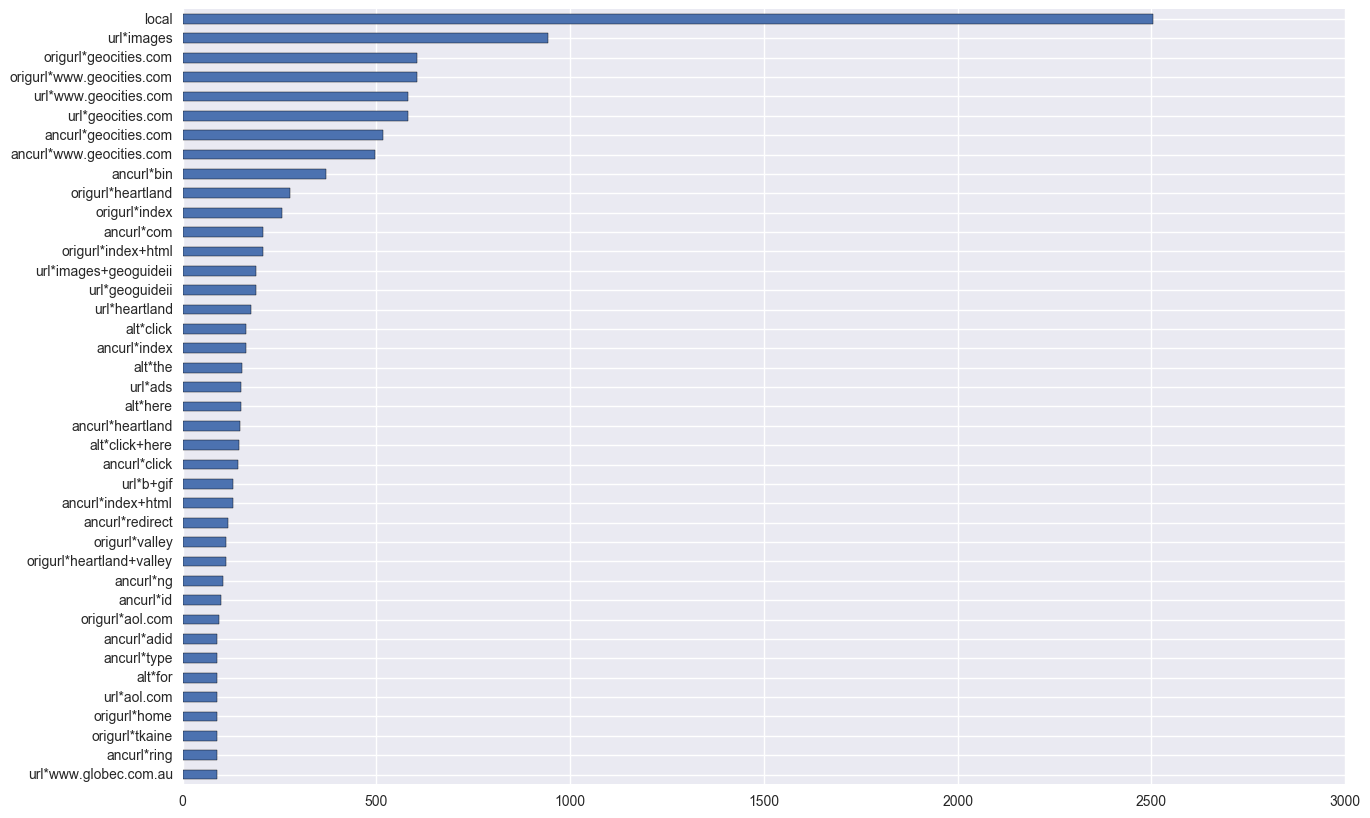

In [8]:
data[dummy_var_cols].sum().sort_values().tail(40).plot(kind="barh", figsize=(15,10))

Let's also take a look at the continuous variables

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x129f74710>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12a0138d0>]], dtype=object)

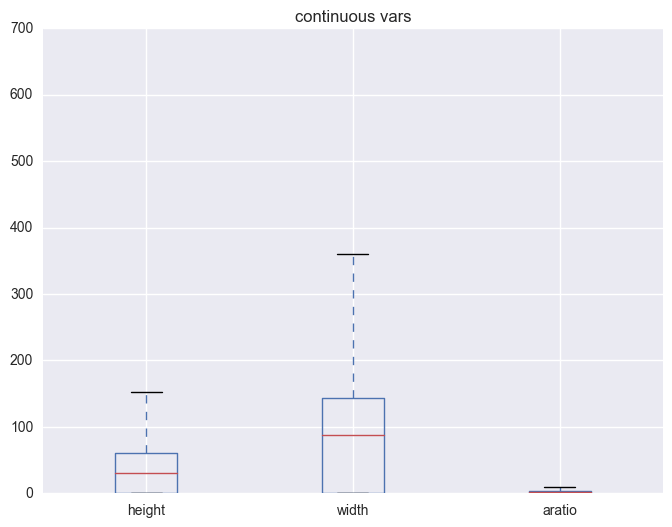

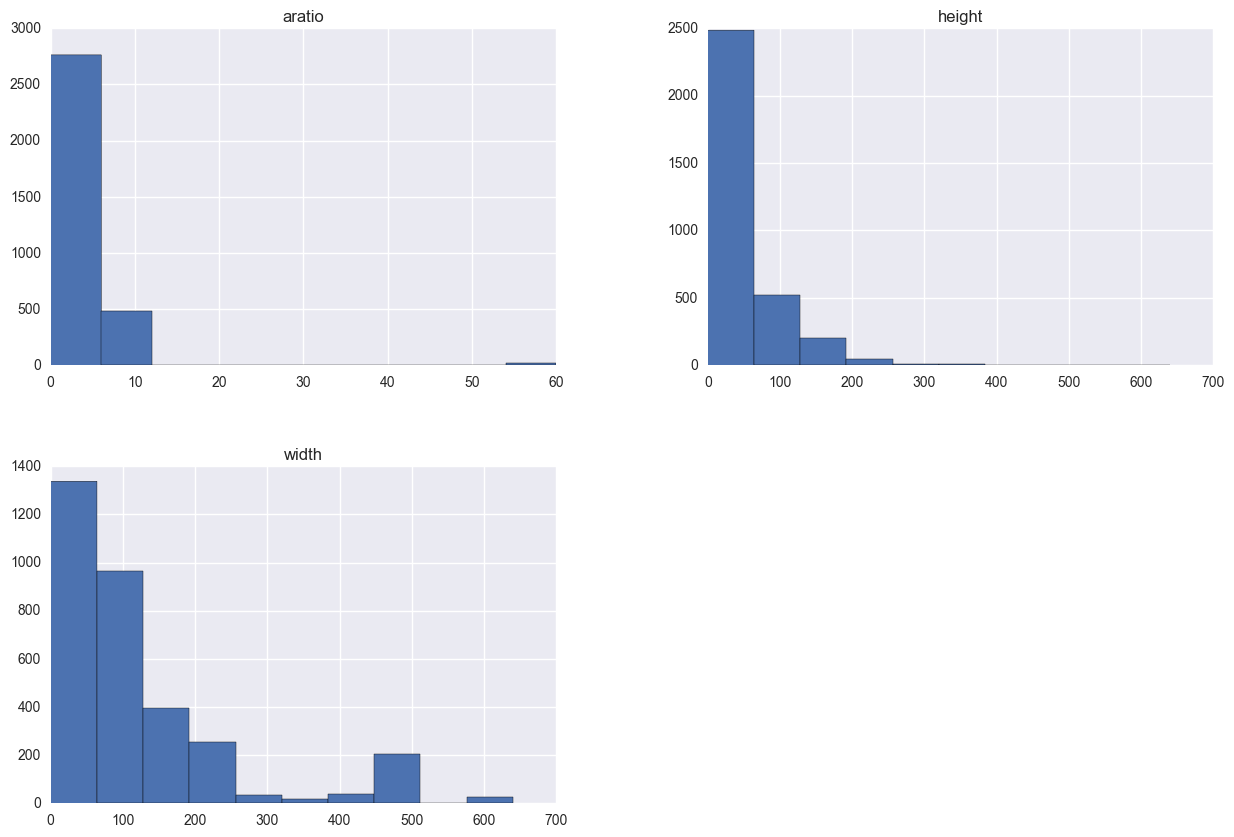

In [14]:
data[continuous_var_cols].plot(kind="box", title="continuous vars", figsize=(8,6))
data[continuous_var_cols].hist(figsize=(15,10))

All of the continuous variables are highly skewed, probably a good idea to log transform and center MinMax scale them to treat parameters fairly (In hindsight, this also is a prior we're introducing to the model).

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x118e7aa20>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12cec8e10>]], dtype=object)

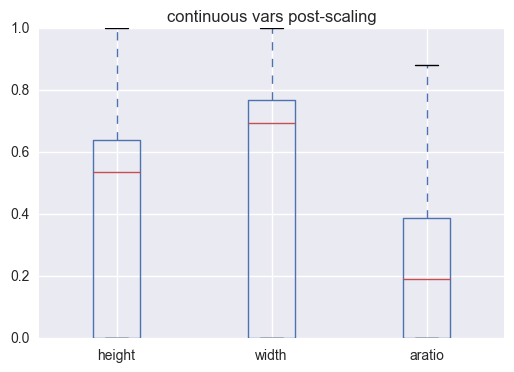

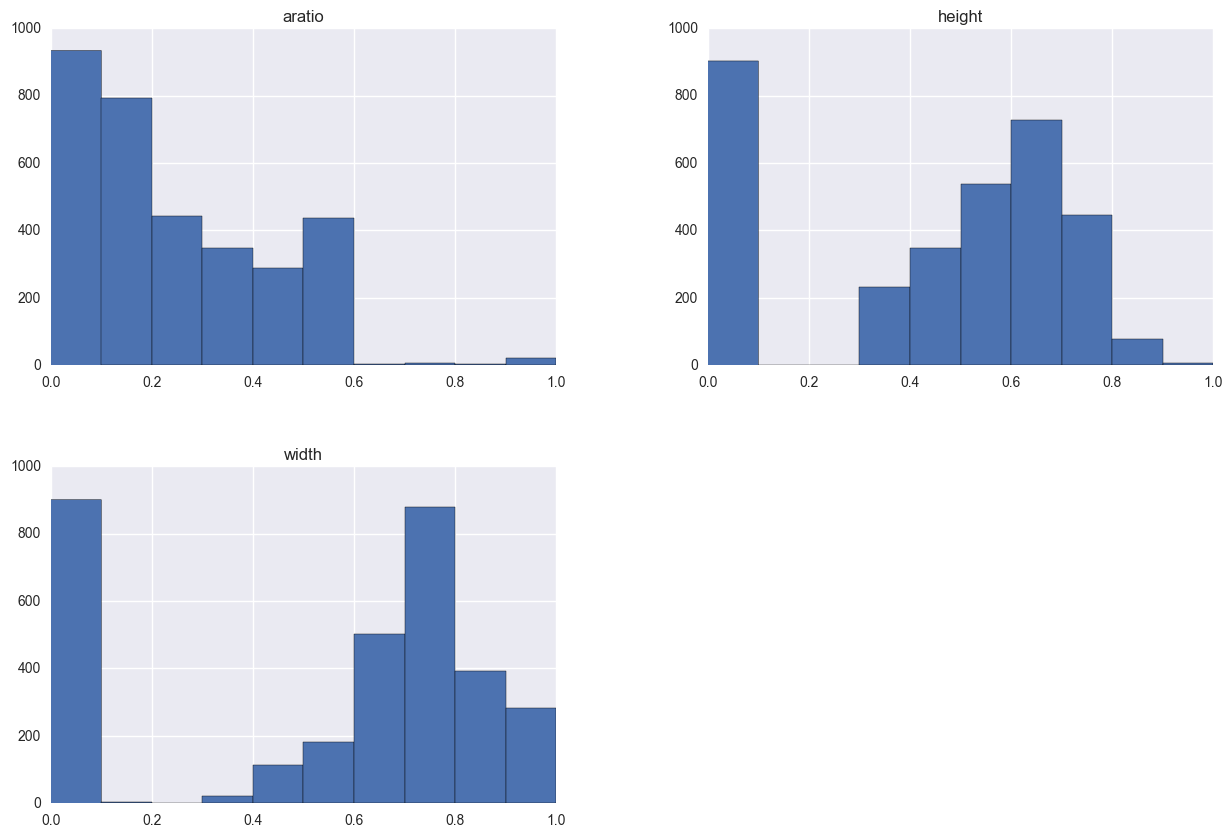

In [23]:
features = data[continuous_var_cols + dummy_var_cols]

# _ apply log scale
features.loc[:, continuous_var_cols] = features[continuous_var_cols].apply(lambda x: np.log(x + 1))

from sklearn.preprocessing import MinMaxScaler

# _ scale the image size cols
scaler = MinMaxScaler()
features.loc[:, continuous_var_cols] = scaler.fit_transform(features[continuous_var_cols])

# _ visualize
features[continuous_var_cols].plot(kind="box", title="continuous vars post-scaling")
features[continuous_var_cols].hist(figsize=(15,10))

Let's also take a look at how ad vs non-ad classes are distributed

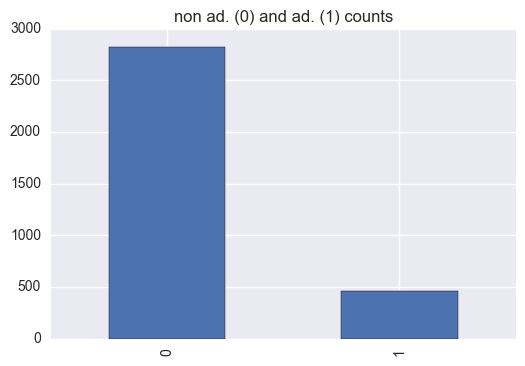

In [24]:
# encode numerical values to the class 1 means image is an ad
classes = data[class_col].apply(lambda x: 1 if x == "ad." else 0)
classes.value_counts().plot(kind="bar", title="non ad. (0) and ad. (1) counts")

### We're now ready to build our first model

It's a good idea to split the set we have available into train and test sets. 80% of the data will be used for training and 20% for testing

In [25]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, classes, test_size=0.2, random_state=0)

print("Training set has {} observations and {} features".format(X_train.shape[0], X_train.shape[1]))
print("Testing set has {} observations and {} features".format(X_test.shape[0], X_test.shape[1]))

Training set has 2623 observations and 1558 features
Testing set has 656 observations and 1558 features


I'll try to use 3 models

- Gaussian Naive Bayes
- Logistic Regression
- Ensemble Methods 
    - Gradient Boosting Classifier
    - ADA Boost Classifier
    
    
We will train each classifier and measure its performance to rank models later. Performance metric we will be using is going to be [f1 score](https://en.wikipedia.org/wiki/F1_score) instead of pure [accuracy](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) since the former will consider both [precision and recall](http://www.markhneedham.com/blog/wp-content/uploads/2015/02/false_positive_negative.jpg)

In [66]:
from sklearn.metrics import accuracy_score, fbeta_score

# _ define a routine to apply learning
def train_predict(learner, X_train, y_train, X_test, y_test, beta): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    start = time() # Get start time
    learner = clf.fit(X_train, y_train)
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set,
    # then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = clf.predict(X_test)
    predictions_train = clf.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta)
        
    # Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test, predictions_test, beta)
            
    # Return the results
    print("{} trained".format(learner.__class__.__name__))
    return results

In [41]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier

clf_NB = GaussianNB()
clf_LR = LogisticRegression(random_state=1)
clf_GBC = GradientBoostingClassifier(random_state=1)
clf_ADA = AdaBoostClassifier(random_state=1)

clfs = [clf_NB, clf_LR, clf_GBC, clf_ADA]

results = {}
for clf in clfs:
    clfname = clf.__class__.__name__
    results[clfname] = train_predict(clf, X_train, y_train, X_test, y_test, beta=.5)

display(DataFrame.from_dict(results).T)

,acc_test,acc_train,f_test,f_train,pred_time,train_time
AdaBoostClassifier,0.974085,0.973333,0.919220,0.940860,0.057718,0.957941
GaussianNB,0.766768,0.803333,0.374332,0.470852,0.058279,0.185589
GradientBoostingClassifier,0.978659,0.986667,0.929919,0.979381,0.022639,5.432480
LogisticRegression,0.981707,0.976667,0.936675,0.961538,0.013305,0.099037


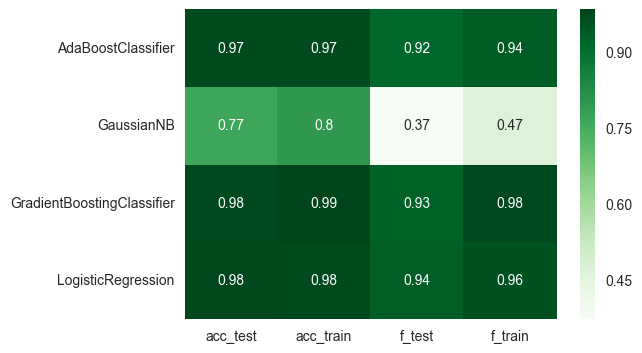

In [68]:
# results_df = DataFrame.from_dict(results).T
sns.heatmap(results_df[['acc_test', 'acc_train', 'f_test', 'f_train']], annot=True, cmap="Greens")


### LOGISTIC REGRESSION is the WINNER 🎉

Although the accuracy scores for 2 boosted algorithms and Logistic Regression (LR) is quite similar f1 score for LR model is slightly better than the others.

#### Optimization Discussion

- **K-fold Cross Validation**

    We can split the training data further into train-test sets to avoid a overfitted model, this can potentially change rankings amongst classifiers that are already pretty close to one another


- **Grid Search for Logistic Regression**

    Assuming Logistic Regression is still the top-performing model we can do a grid search on its [parameters](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) to optimize for our data


- **Feature Reduction**

    As part of the initial analysis we've seen duplicate websites such as `geocities.com` and `www.geocities.com` for the same feature channels (ie `ancurl` or `url`). To reduce the amount of features fed into the models, we can consider consolidating duplicate websites into single entities.

    For this, we would need to inverse OneHot Coding and re-create it after consolidating duplicates.

    This will be further useful since our data is already sparse and we need a decent amount of observations to play nice with [Occam's Razor](https://en.wikipedia.org/wiki/Occam%27s_razor)



In [57]:
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import ShuffleSplit
from sklearn.metrics import make_scorer


cv_sets = ShuffleSplit(X_train.shape[0], n_iter=10, test_size=.2, random_state=1)
clf = LogisticRegression(random_state=1)

parameters = {
    "penalty": ["l2"],
    "C": [.2, .5, .7, .9, 1.0],
    "solver": ["liblinear", "sag"]
}
scorer = make_scorer(fbeta_score, beta=.5)

grid_obj = GridSearchCV(clf, parameters, cv=cv_sets, scoring=scorer)

grid_fit = grid_obj.fit(X_train, y_train)

In [46]:
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.6f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.6f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.6f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.6f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.981707
F-score on testing data: 0.936675

Optimized Model
------
Final accuracy score on the testing data: 0.981707
Final F-score on the testing data: 0.936675


Best classifier for this case seems to be the one with the default parameters